In [1]:
%run notebook_setup

/home/circleci/project/docs/examples/notebook_setup.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


If you have not already read it, you may want to start with the first tutorial: [Getting started with The Joker](1-Getting-started.ipynb).

# Inferring calibration offsets between instruments

Also in addition to the default linear parameters (see [Tutorial 1](1-Getting-started.ipynb), or the documentation for ``JokerSamples.default()``), *The Joker* allows adding linear parameters to account for possible calibration offsets between instruments. For example, there may be an absolute velocity offset between two spectrographs. Below we will demonstrate how to simultaneously infer and marginalize over a constant velocity offset between two simulated surveys of the same "star".

First, some imports we will need later:

In [2]:
import astropy.table as at
import astropy.units as u
from astropy.visualization.units import quantity_support
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import corner
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import exoplanet.units as xu
import arviz as az

import thejoker as tj

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# set up a random number generator to ensure reproducibility
rnd = np.random.default_rng(seed=42)

The data for our two surveys are stored in two separate CSV files included with the documentation. We will load separate `RVData` instances for the two data sets and append these objects to a list of datasets:

In [4]:
data = []
for filename in ['data-survey1.ecsv', 'data-survey2.ecsv']:
    tbl = at.QTable.read(filename)
    _data = tj.RVData.guess_from_table(tbl, t_ref=tbl.meta['t_ref'])
    data.append(_data)

In the plot below, the two data sets are shown in different colors:

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


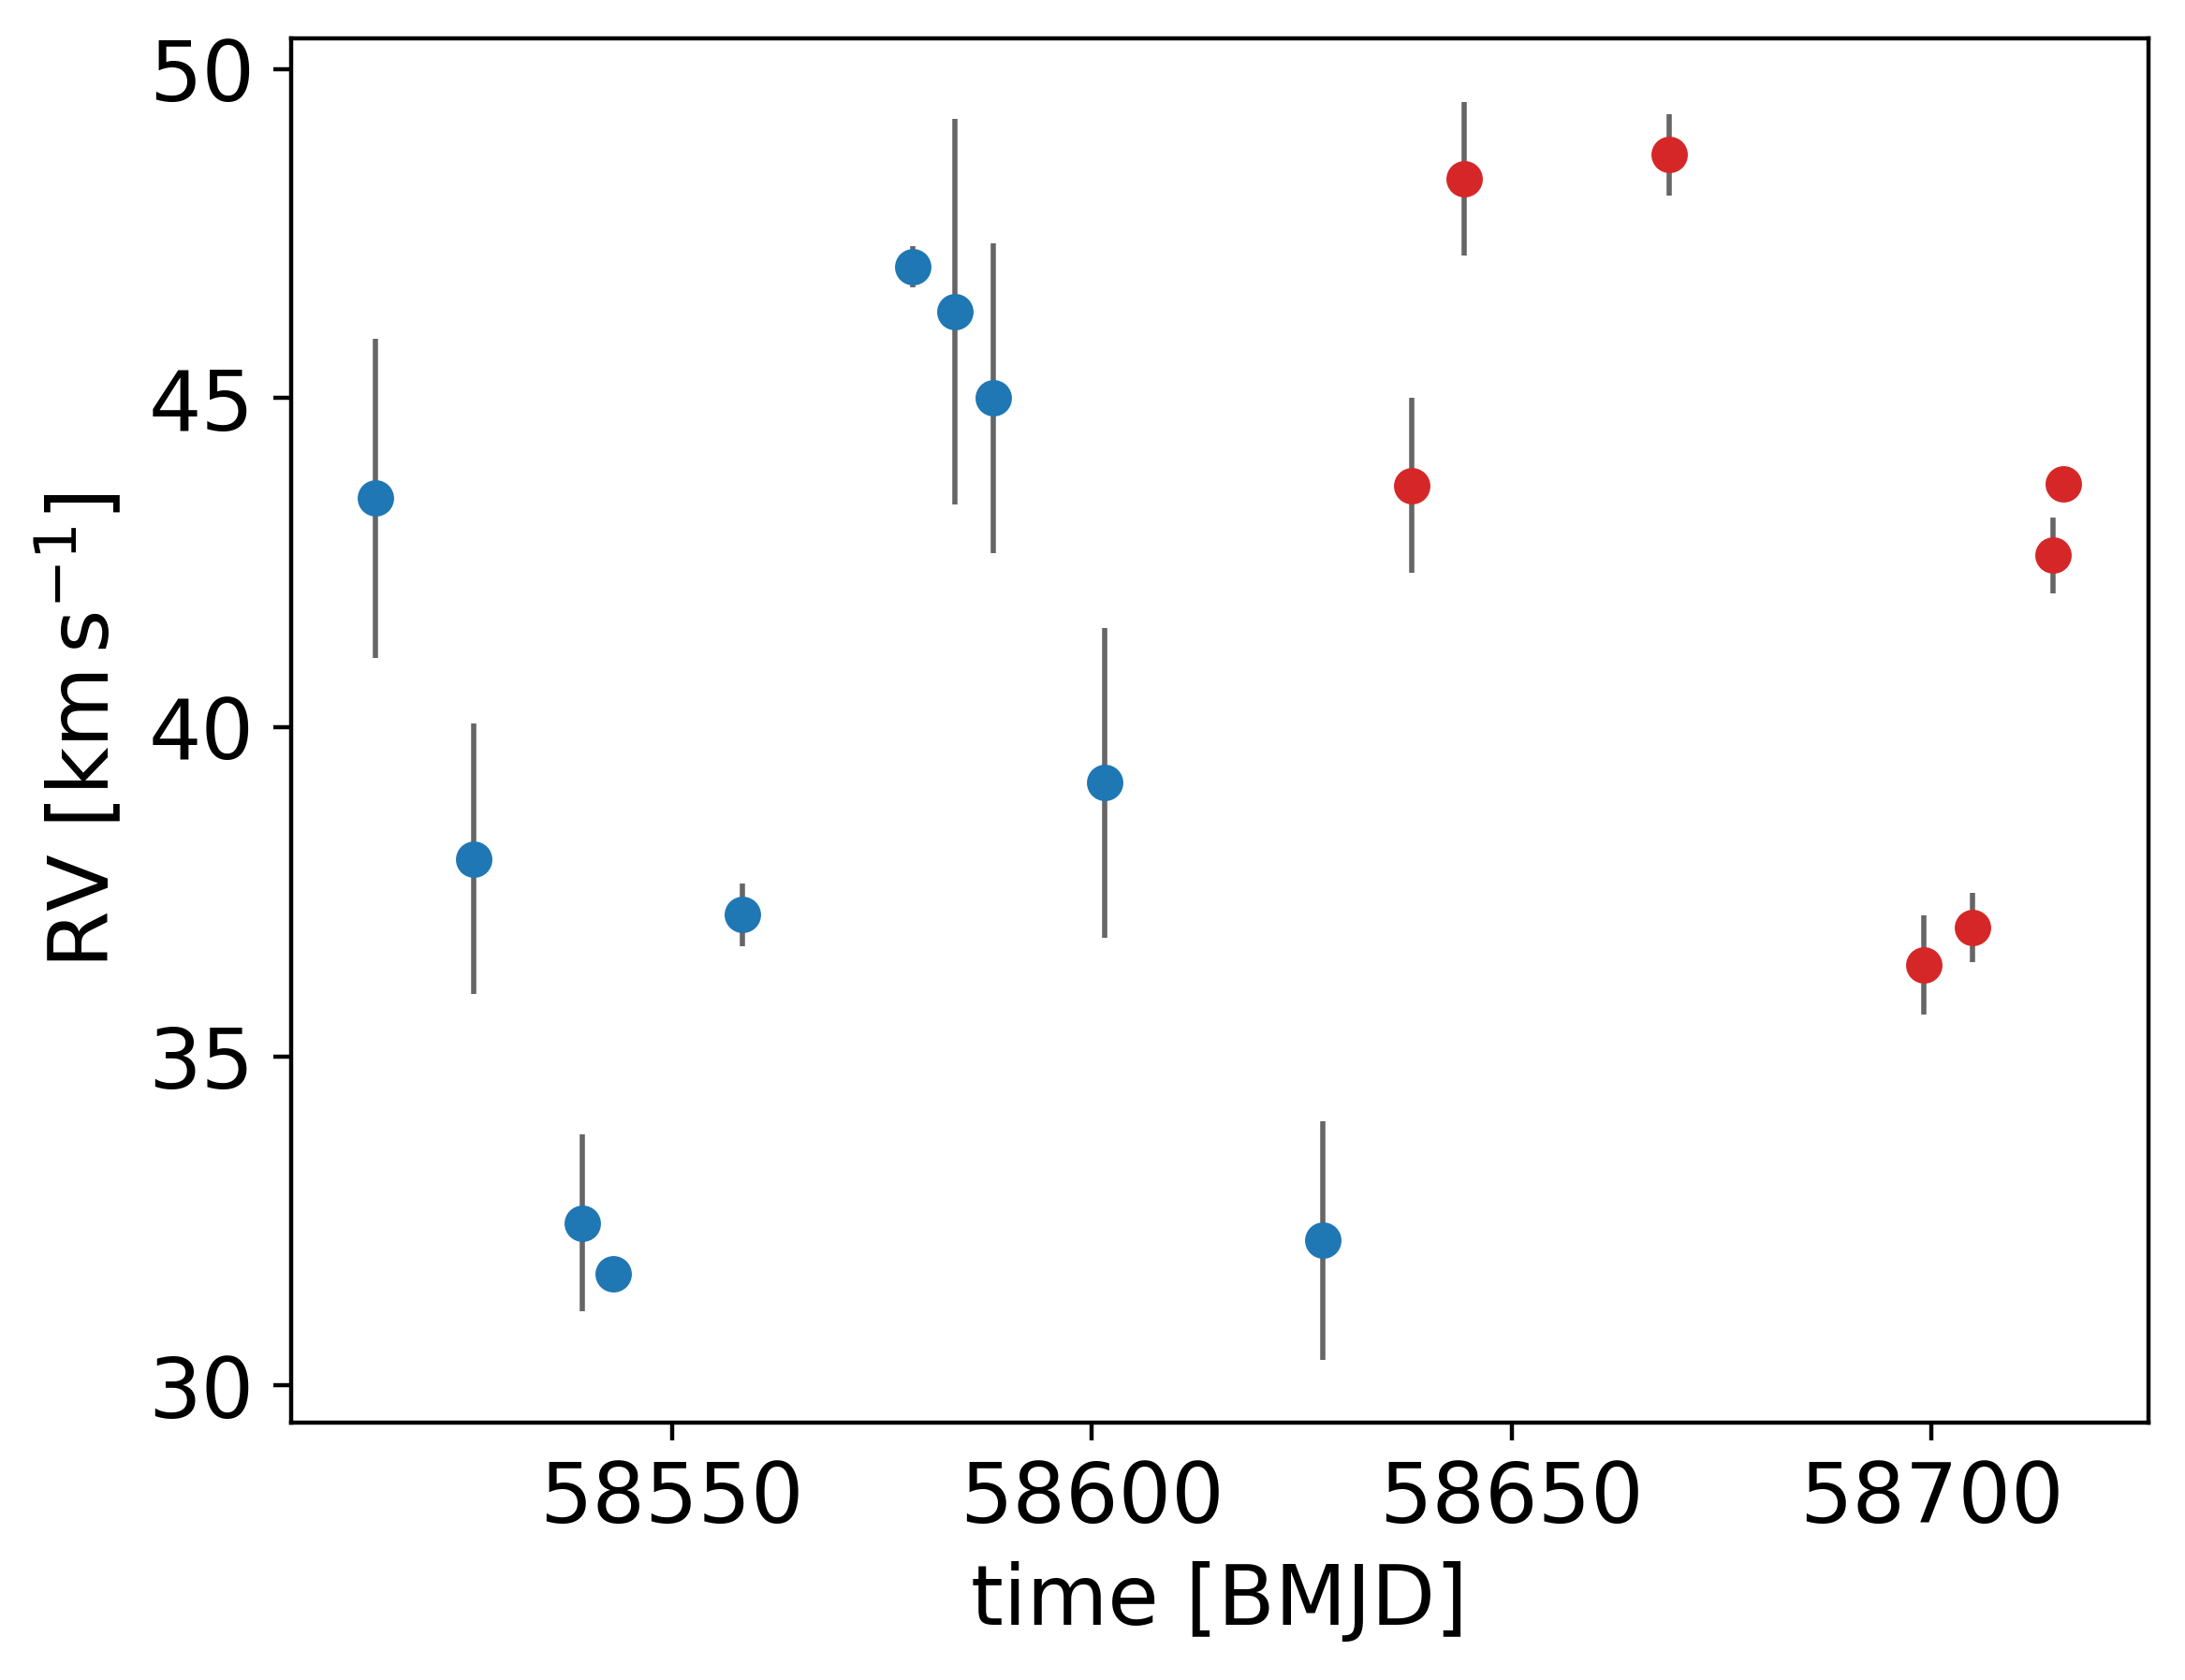

In [5]:
for d, color in zip(data, ['tab:blue', 'tab:red']):
    _ = d.plot(color=color)

To tell *The Joker* to handle additional linear parameters to account for offsets in absolute velocity, we must define a new parameter for the offset betwen survey 1 and survey 2 and specify a prior. Here we will assume a Gaussian prior on the offset, centered on 0, but with a 10 km/s standard deviation. We then pass this in to `JokerPrior.default()` (all other parameters here use the default prior) through the `v0_offsets` argument:

In [6]:
with pm.Model() as model:
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 10),
                         u.km/u.s)
    
    prior = tj.JokerPrior.default(
        P_min=2*u.day, P_max=256*u.day,
        sigma_K0=30*u.km/u.s,
        sigma_v=100*u.km/u.s,
        v0_offsets=[dv0_1])

The rest should look familiar: The code below is identical to previous tutorials, in which we generate prior samples and then rejection sample with *The Joker*:

In [7]:
prior_samples = prior.sample(size=1_000_000,
                             random_state=rnd)

In [8]:
joker = tj.TheJoker(prior, random_state=rnd)
joker_samples = joker.rejection_sample(data, prior_samples, 
                                       max_posterior_samples=128)
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (9 samples)>

Note that the new parameter, `dv0_1`, now appears in the returned samples above.

If we pass these samples in to the `plot_rv_curves` function, the data from other surveys is, by default, shifted by the mean value of the offset before plotting:

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


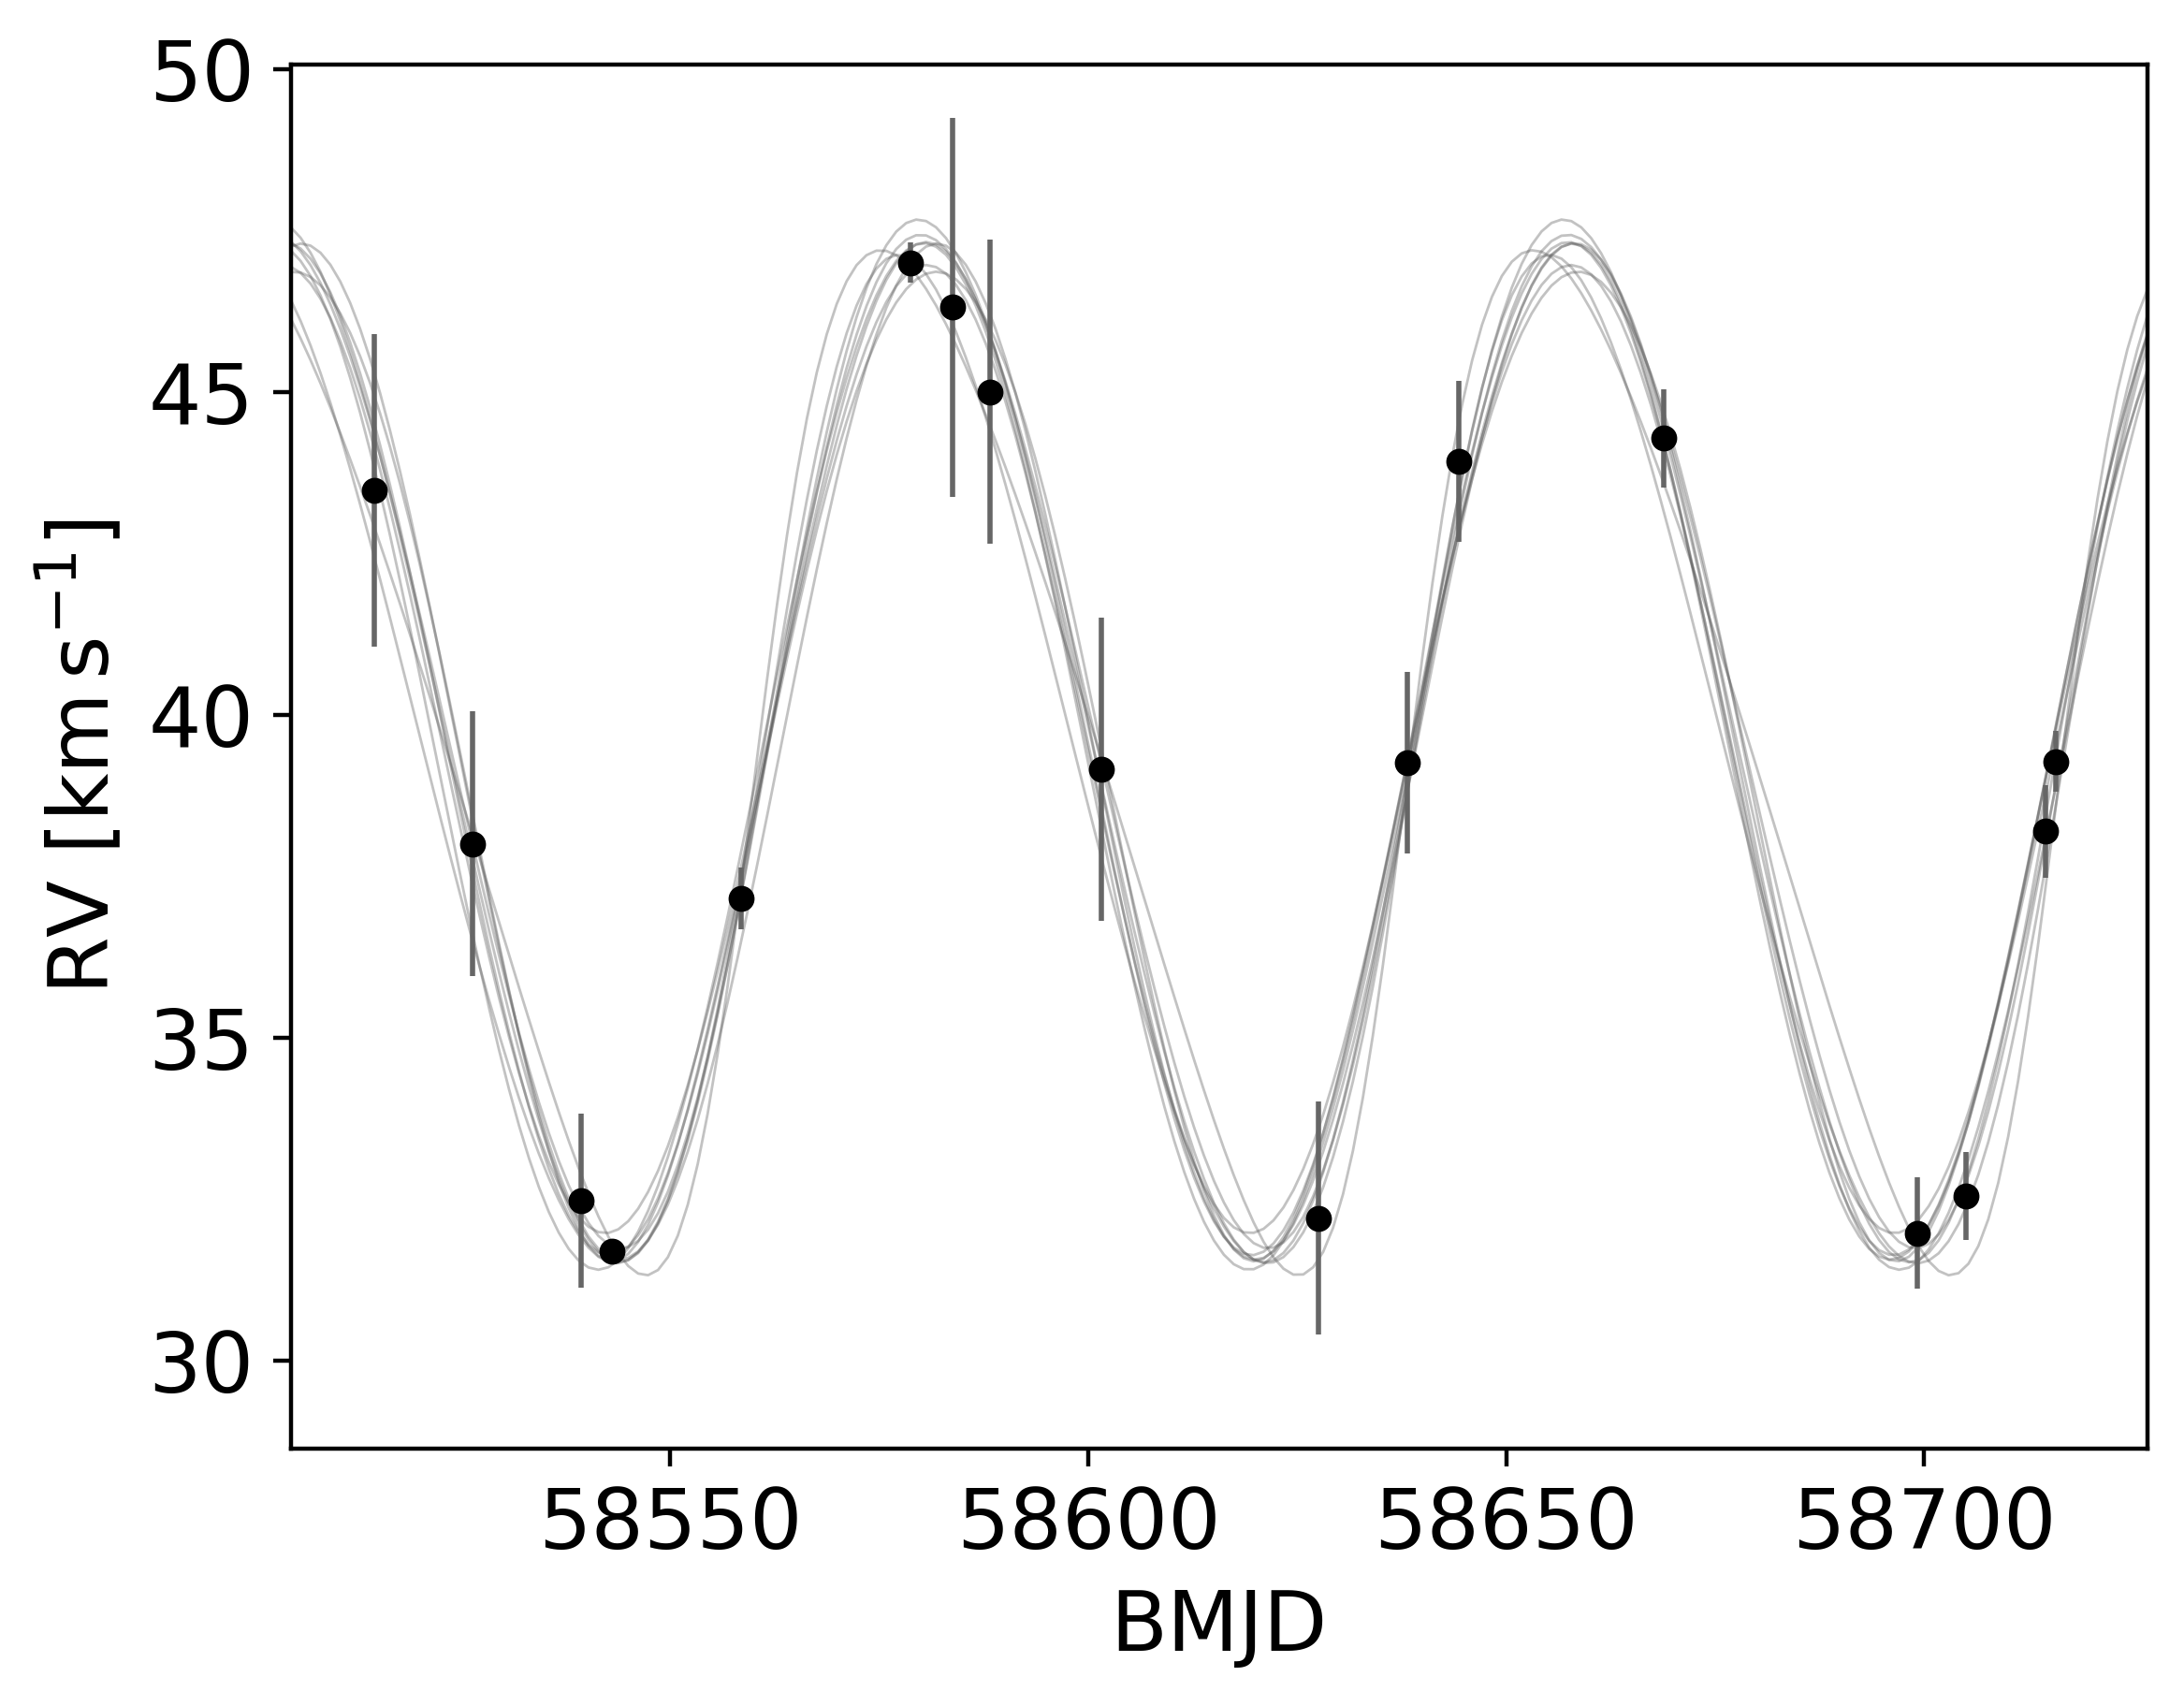

In [9]:
_ = tj.plot_rv_curves(joker_samples, data=data)

However, the above behavior can be disabled by setting `apply_mean_v0_offset=False`. Note that with this set, the inferred orbit will not generally pass through data that suffer from a measurable offset:

findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


findfont: Generic family 'serif' not found because none of the following families were found: Liberation Serif


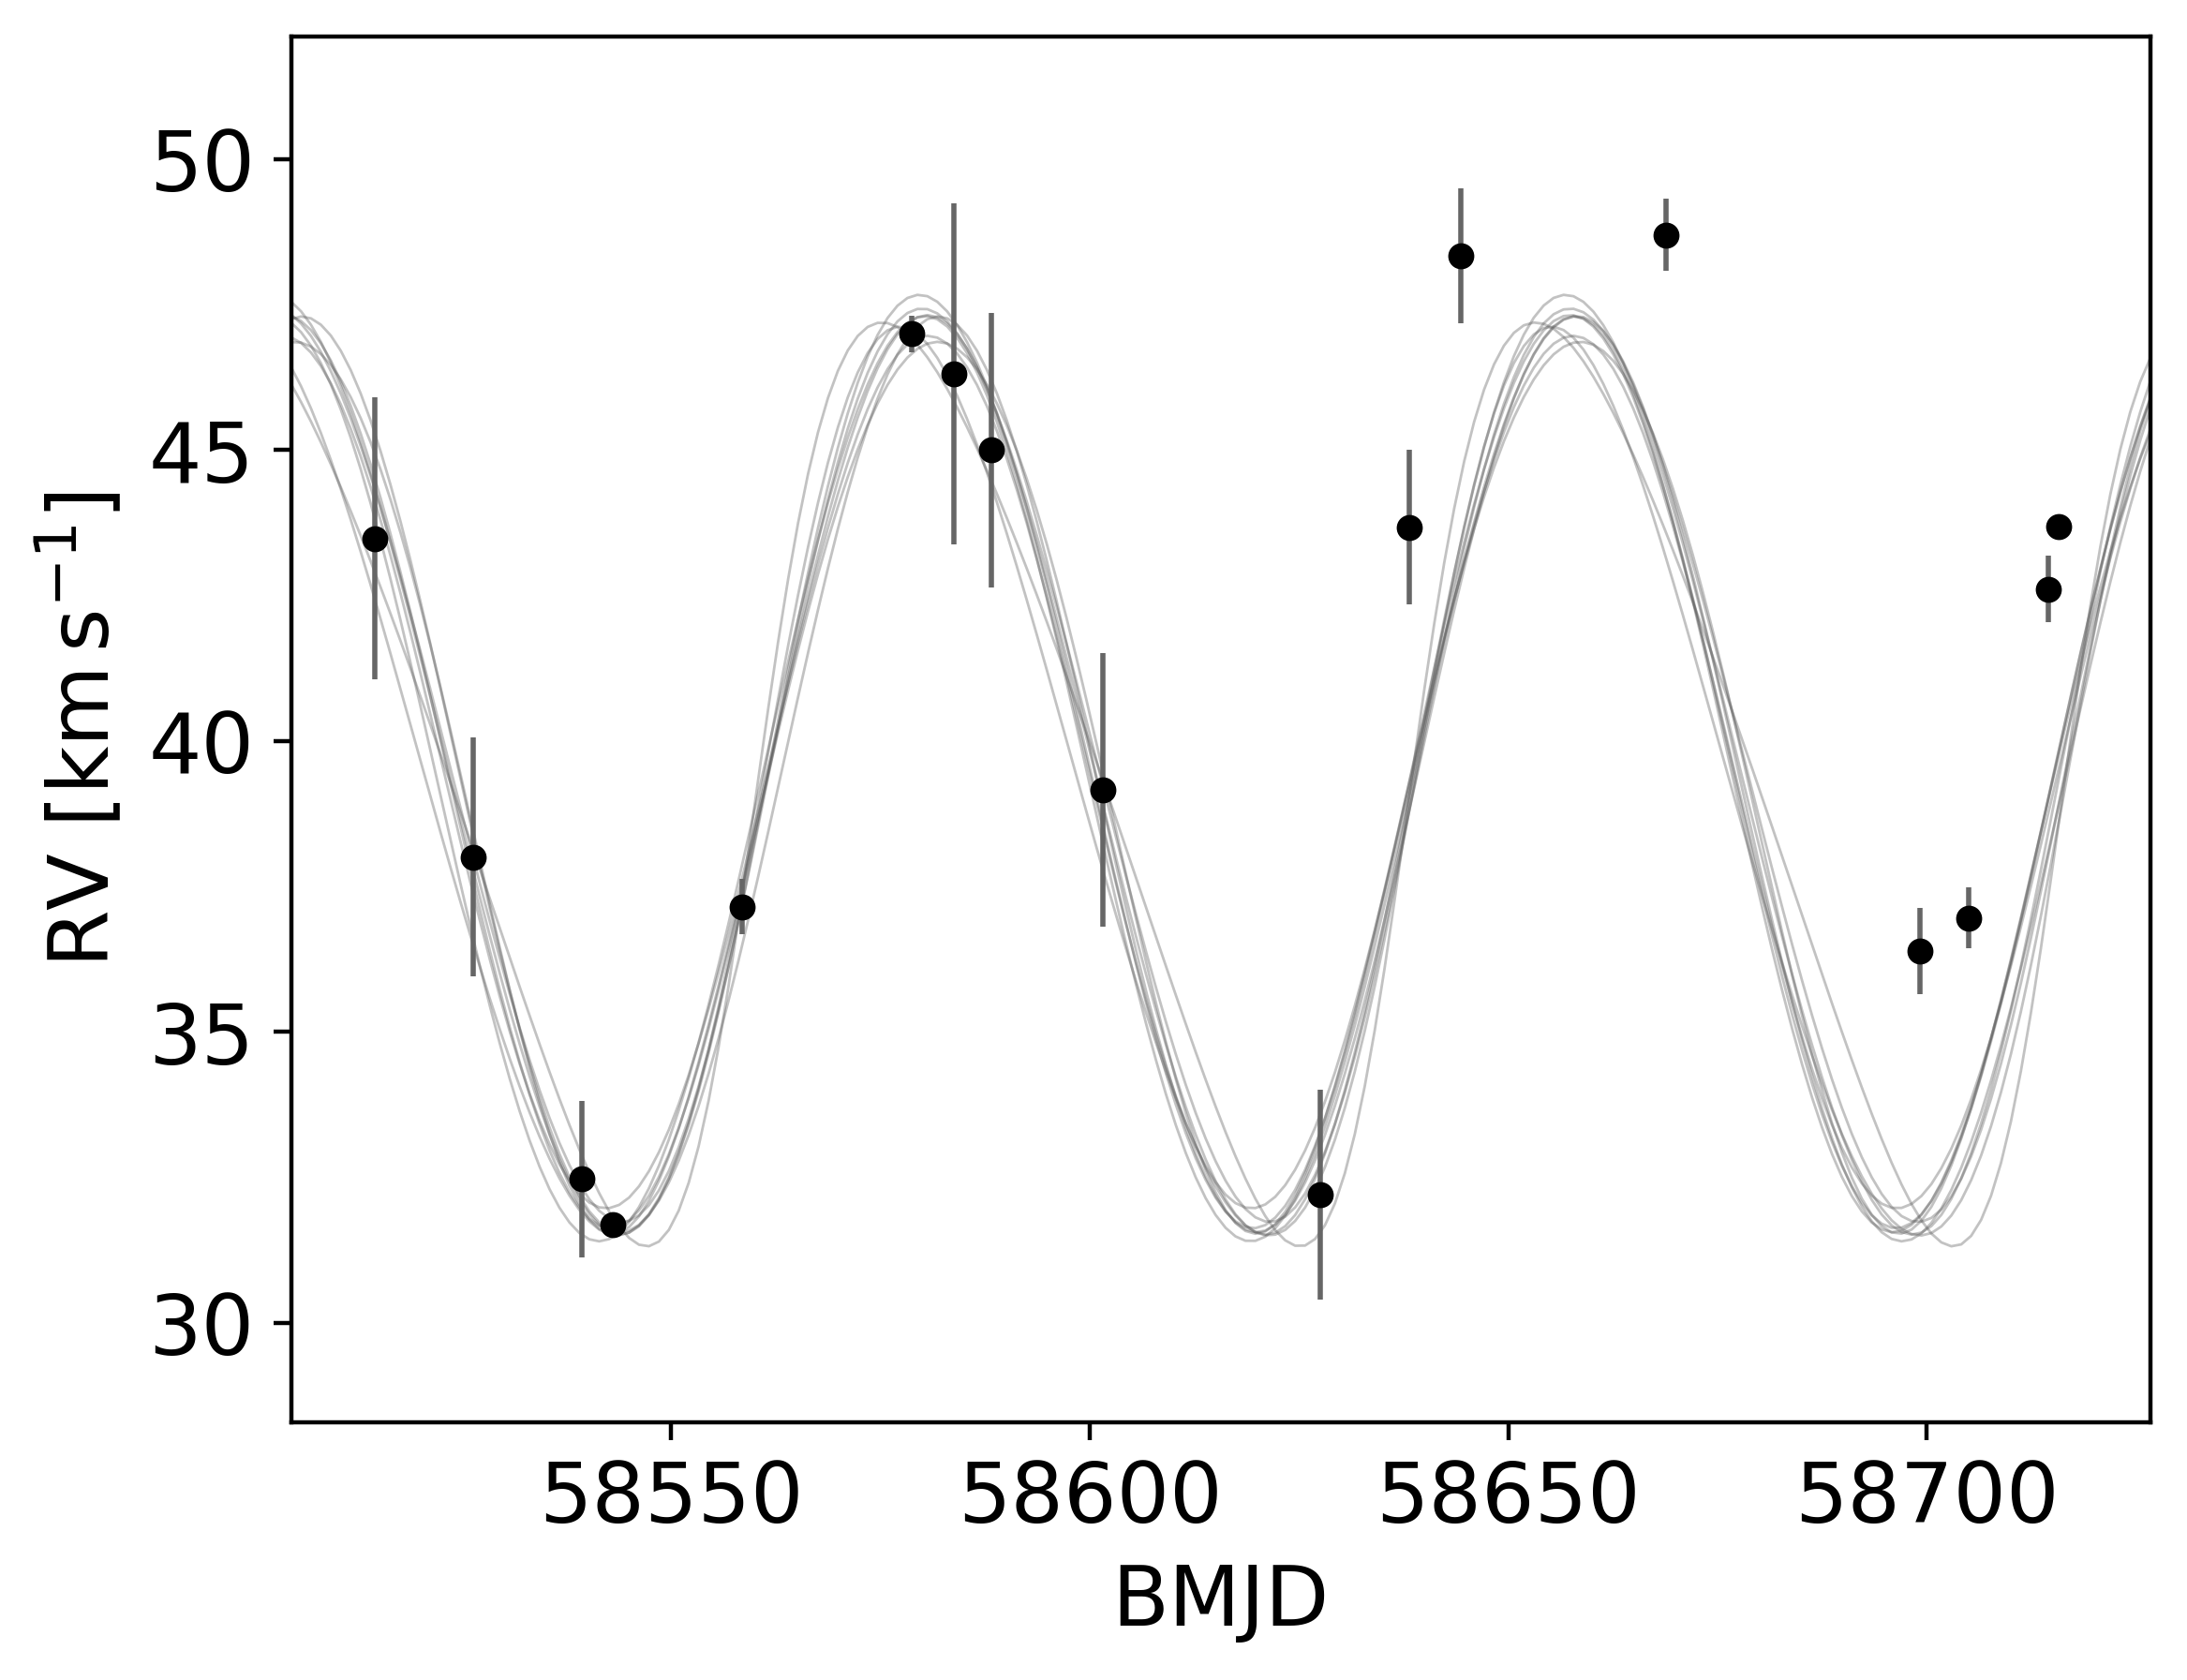

In [10]:
_ = tj.plot_rv_curves(joker_samples, data=data, 
                      apply_mean_v0_offset=False)

As introduced in the previous tutorial, we can also continue generating samples by initializing and running standard MCMC:

In [11]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, joker_samples)
    
    trace = pmx.sample(
        tune=500, draws=500, 
        start=mcmc_init,
        cores=1, chains=2)

Sequential sampling (2 chains in 1 job)


NUTS: [v0, K, P, M0, omega, e, dv0_1]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 28 seconds.


The number of effective samples is smaller than 25% for some parameters.


In [12]:
az.summary(trace, var_names=prior.par_names)

Got error No model on context stack. trying to find log_likelihood in translation.


/home/circleci/project/venv/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
P      76.976  0.530  75.903   77.856      0.024    0.017     483.0     605.0   
e       0.055  0.045   0.000    0.138      0.003    0.002     223.0     460.0   
omega   0.713  1.447  -2.629    2.770      0.121    0.104     226.0     363.0   
M0     -0.969  2.111  -3.136    2.944      0.127    0.163     341.0     609.0   
s       0.000  0.000   0.000    0.000      0.000    0.000    1000.0    1000.0   
K      -7.764  0.173  -8.063   -7.412      0.007    0.005     561.0     576.0   
v0     39.474  0.237  39.023   39.898      0.013    0.009     318.0     658.0   
dv0_1   4.303  0.482   3.462    5.190      0.020    0.014     580.0     460.0   

       r_hat  
P       1.00  
e       1.00  
omega   1.01  
M0      1.00  
s        NaN  
K       1.00  
v0      1.00  
dv0_1   1.00

Here the true offset is 4.8 km/s, so it looks like we recover this value!

A full corner plot of the MCMC samples:

In [13]:
mcmc_samples = joker.trace_to_samples(trace, data)
mcmc_samples.wrap_K()

/home/circleci/project/thejoker/thejoker.py:492: UserWarning: This method is deprecated: Use thejoker.samples_helpers.trace_to_samples() instead
  warnings.warn(


<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (1000 samples)>

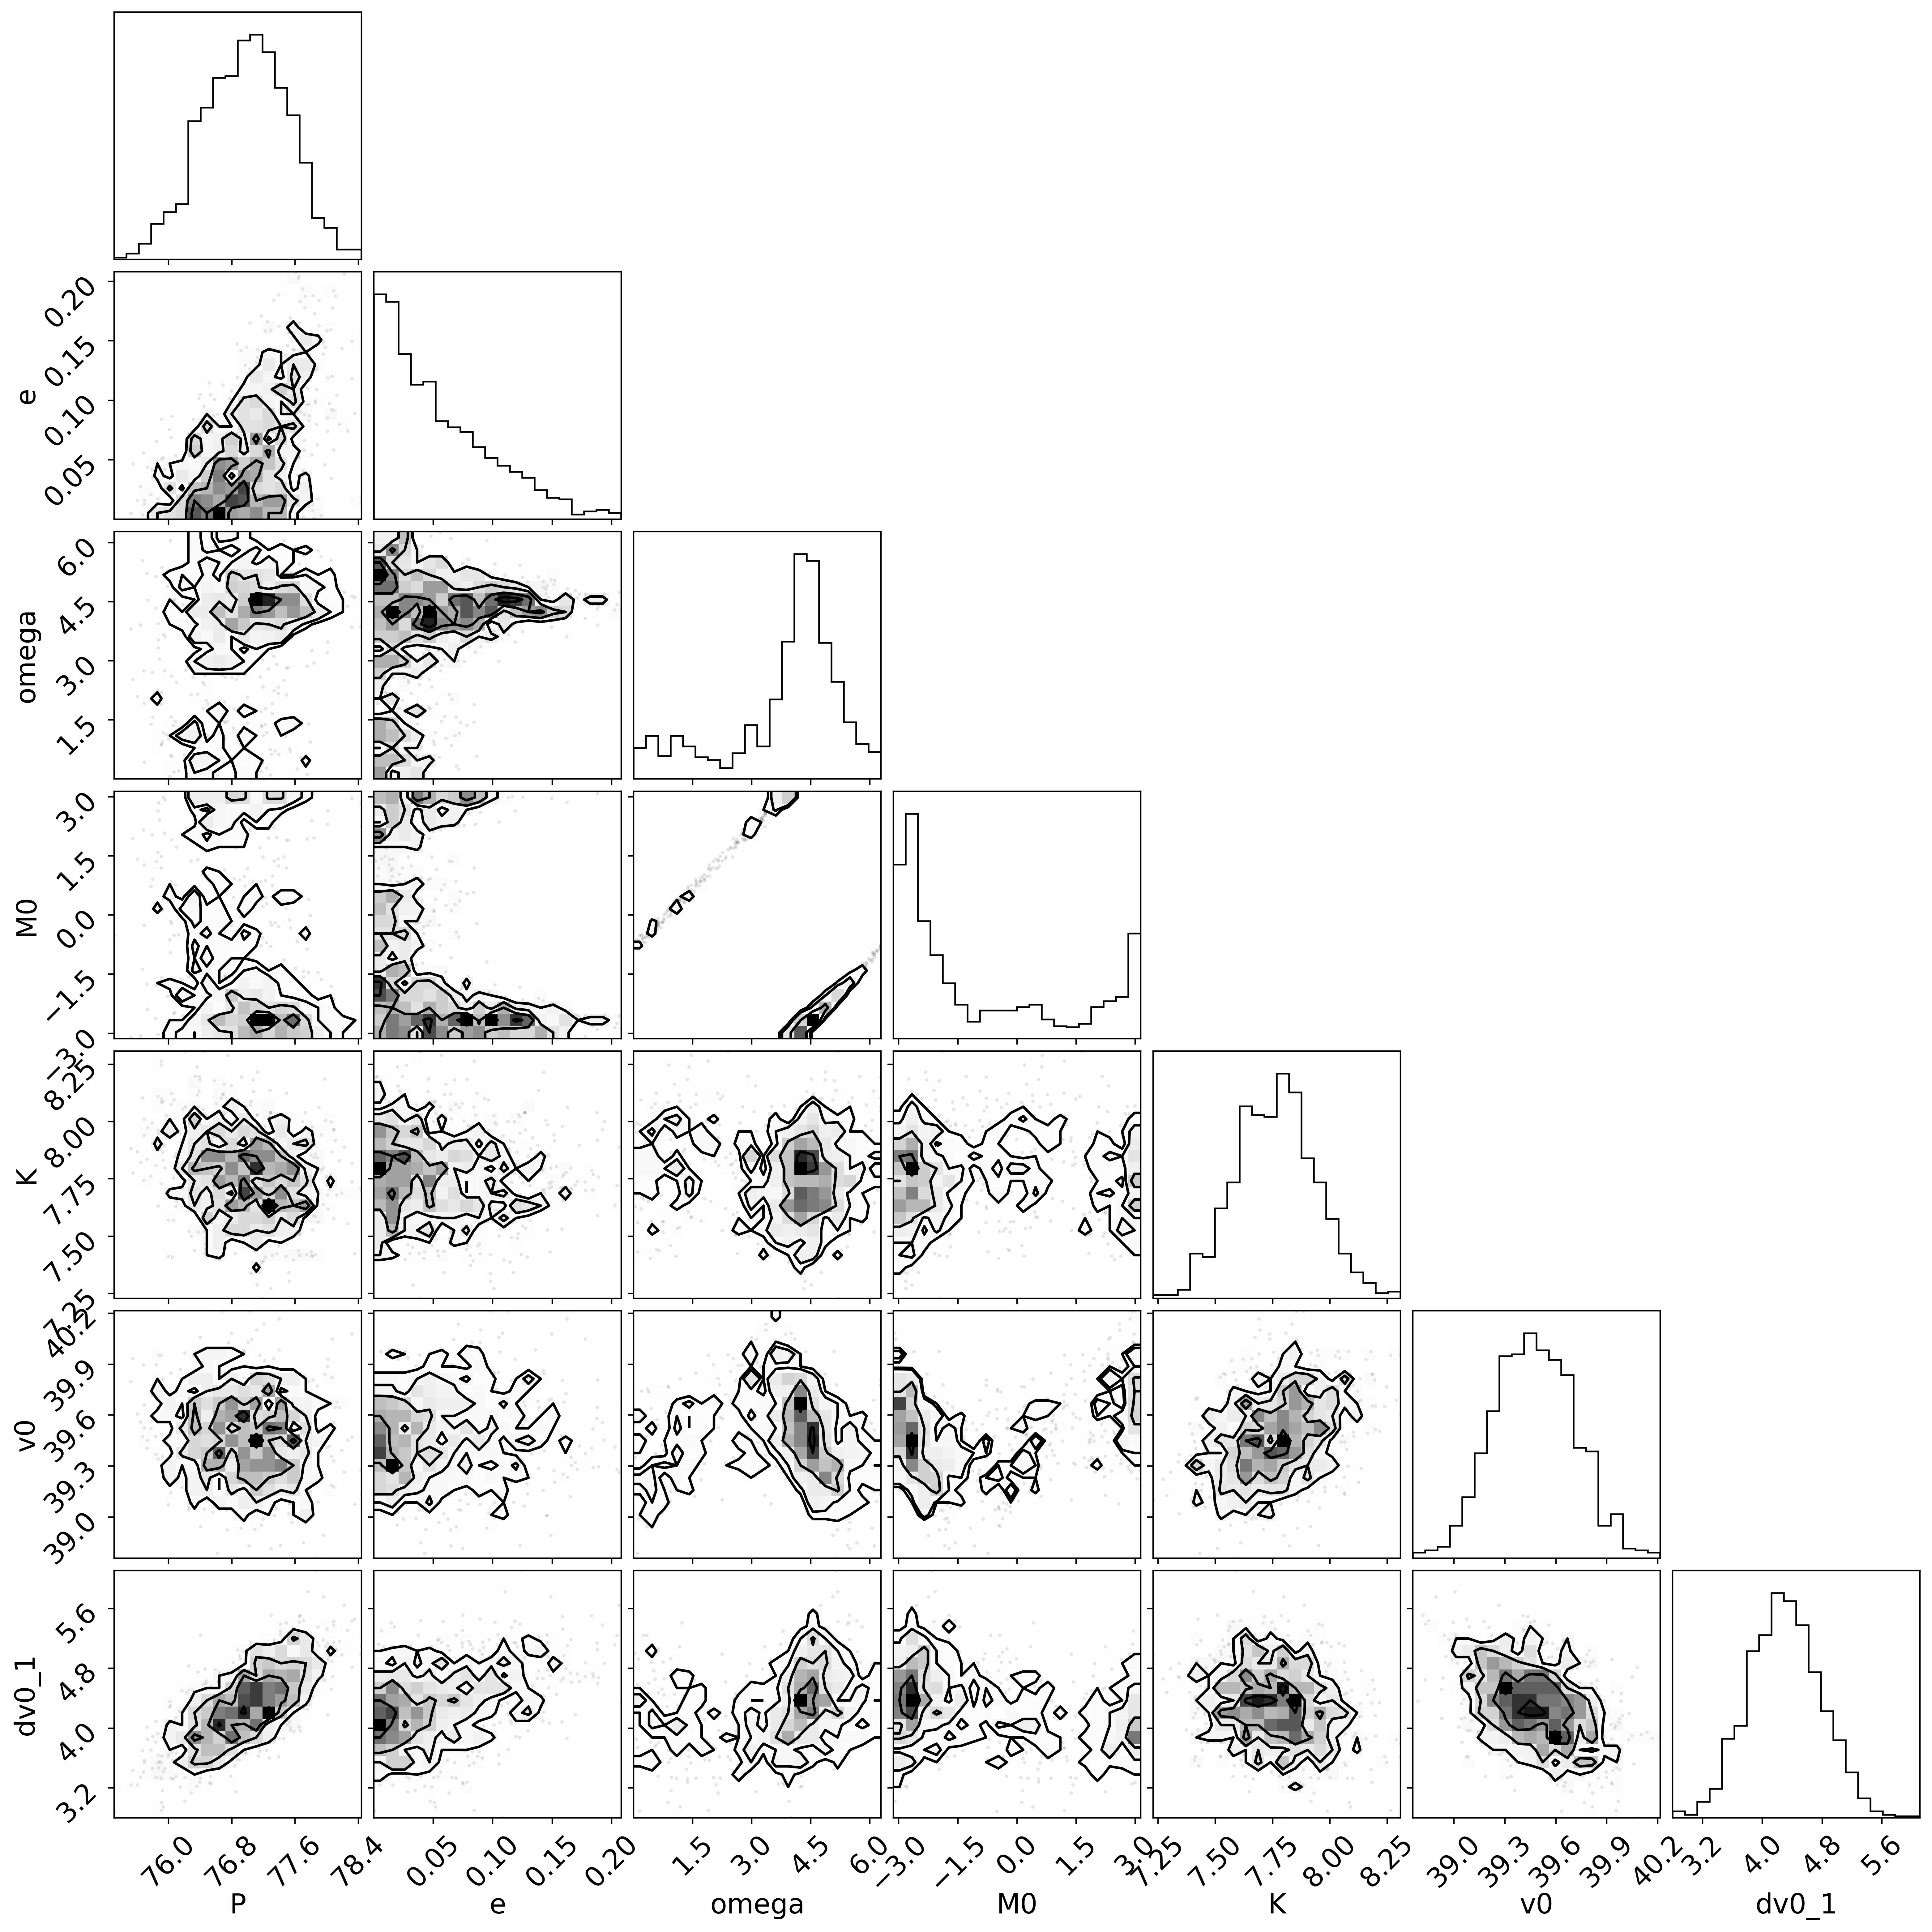

In [14]:
df = mcmc_samples.tbl.to_pandas()
colnames = mcmc_samples.par_names
colnames.pop(colnames.index('s'))
_ = corner.corner(df[colnames])